In [114]:
import pandas as pd
import matplotlib.pyplot as plt
import math
from math import comb
import numpy as np
import statsmodels.stats.proportion as smp
from scipy import stats
import networkx as nx
import random
from abc import ABC, abstractmethod
from scipy.stats import linregress

# Helpers

In [77]:
def printf(s):
    print(f"{s:.20f}")

# Building dataframes

In [78]:
wdf = pd.read_csv("./CoW_Inter-StateWarData_v4.0.csv")

In [79]:
# Read polity data, make timeseries
pdf = pd.read_csv("./p5.csv")

def b_e_to_list(row):
    byear = row['byear']
    eyear = row['eyear'] if (row['eyear'] != 9999) else 2019 # Avoid huge thingy
    
    return list(range(byear, eyear))

pdf['years'] = pdf.apply (lambda row: b_e_to_list(row), axis=1)
pdf = pdf[pdf.years.map(len) > 0] # let's ignore transitions within a year
pdf = pdf.explode('years')
pdf = pdf.rename(columns={'years': 'year'})
pdf = pdf.loc[(pdf.year >= 1823) & (pdf.year < 2019)] # start of conflict data to 2018 (2019 sucks)

# update polity scores vaguely based on polity5 rules
def update_polity(row):
    old_polity = row['polity']
    if old_polity == -66: # case of foreign interruption, treat as missing
        return None
    elif old_polity == -77: # anarchy, treat as neutral
        return 0
    elif old_polity == -88: # transition, treat as missing. Will fill in separately
        return None
    else:
        return old_polity

# Sort to make sure fill works as expected
pdf = pdf.sort_values(['ccode', 'year'], ascending=[True, True])
# First move -66 and -88 to nan
pdf['polity'] = pdf.apply (lambda row: update_polity(row), axis=1)
# Then pad forward. 
# Runs a slight risk of first country year being -66 or -88, but that shouldn't be true by definition
pdf['polity'] = pdf['polity'].fillna(method='ffill')

# Select subset of columns for cleanliness
pdf = pdf[['ccode', 'scode', 'country', 'year', 'polity']]

In [80]:
pdf

,ccode,scode,country,year,polity
1588,2,USA,United States,1823,6.0
1588,2,USA,United States,1824,6.0
1589,2,USA,United States,1825,7.0
1589,2,USA,United States,1826,7.0
1589,2,USA,United States,1827,7.0
...,...,...,...,...,...
502,950,FJI,Fiji,2014,2.0
502,950,FJI,Fiji,2015,2.0
502,950,FJI,Fiji,2016,2.0
502,950,FJI,Fiji,2017,2.0


In [81]:
# Create basic dimension table
cdf = pdf.groupby('ccode').agg('first')[['scode', 'country']]

In [82]:
# Dyadic polity dataframe
dpdf = pd.merge(pdf, pdf, on=['year'])
dpdf = dpdf[dpdf.ccode_x > dpdf.ccode_y]

In [83]:
dpdf

,ccode_x,scode_x,country_x,year,polity_x,ccode_y,scode_y,country_y,polity_y
38,41,HAI,Haiti,1823,-3.0,2,USA,United States,6.0
76,70,MEX,Mexico,1823,-1.0,2,USA,United States,6.0
77,70,MEX,Mexico,1823,-1.0,41,HAI,Haiti,-3.0
114,99,GCL,Gran Colombia,1823,-1.0,2,USA,United States,6.0
115,99,GCL,Gran Colombia,1823,-1.0,41,HAI,Haiti,-3.0
...,...,...,...,...,...,...,...,...,...
1780025,950,FJI,Fiji,2018,4.0,860,ETM,Timor Leste,8.0
1780026,950,FJI,Fiji,2018,4.0,900,AUL,Australia,10.0
1780027,950,FJI,Fiji,2018,4.0,910,PNG,Papua New Guinea,5.0
1780028,950,FJI,Fiji,2018,4.0,920,NEW,New Zealand,10.0


In [84]:
# Make full dataframe
# Note that this assumes polity stays the same for the duration of a conflict
mdf = pd.merge(wdf, pdf, how='left', left_on=['ccode','StartYear1'], right_on = ['ccode','year'])

In [85]:
mdf

,WarNum,WarName,WarType,ccode,StateName,Side,StartMonth1,StartDay1,StartYear1,EndMonth1,...,WhereFought,Initiator,Outcome,TransTo,BatDeath,Version,scode,country,year,polity
0,1,Franco-Spanish War,1,230,Spain,2,4,7,1823,11,...,2,2,2,-8,600,4,SPN,Spain,1823,-6.0
1,1,Franco-Spanish War,1,220,France,1,4,7,1823,11,...,2,1,1,-8,400,4,FRN,France,1823,-4.0
2,4,First Russo-Turkish,1,640,Ottoman Empire,2,4,26,1828,9,...,11,2,2,-8,80000,4,TUR,Turkey,1828,-10.0
3,4,First Russo-Turkish,1,365,Russia,1,4,26,1828,9,...,11,1,1,-8,50000,4,RUS,Russia,1828,-10.0
4,7,Mexican-American,1,70,Mexico,2,4,25,1846,9,...,1,2,2,-8,6000,4,MEX,Mexico,1846,-3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
332,225,Invasion of Afghanistan,1,700,Afghanistan,2,10,7,2001,12,...,7,2,4,481,4000,4,AFG,Afghanistan,2001,-7.0
333,227,Invasion of Iraq,1,900,Australia,1,3,19,2003,5,...,6,1,4,482,0,4,AUL,Australia,2003,10.0
334,227,Invasion of Iraq,1,200,United Kingdom,1,3,19,2003,5,...,6,1,4,482,33,4,UKG,United Kingdom,2003,10.0
335,227,Invasion of Iraq,1,2,United States of America,1,3,19,2003,5,...,6,1,4,482,140,4,USA,United States,2003,10.0


In [86]:
# Create full dyad dataframe
ddf = pd.merge(mdf, mdf, on=['WarNum','year'])
ddf = ddf[ddf['ccode_x'] > ddf['ccode_y']] # Removes opposite direction & same country dyads
ddf = ddf[ddf.Side_x != ddf.Side_y] # Removes dyads on same side

In [87]:
ddf

,WarNum,WarName_x,WarType_x,ccode_x,StateName_x,Side_x,StartMonth1_x,StartDay1_x,StartYear1_x,EndMonth1_x,...,TransFrom_y,WhereFought_y,Initiator_y,Outcome_y,TransTo_y,BatDeath_y,Version_y,scode_y,country_y,polity_y
1,1,Franco-Spanish War,1,230,Spain,2,4,7,1823,11,...,503,2,1,1,-8,400,4,FRN,France,-4.0
5,4,First Russo-Turkish,1,640,Ottoman Empire,2,4,26,1828,9,...,506,11,1,1,-8,50000,4,RUS,Russia,-10.0
9,7,Mexican-American,1,70,Mexico,2,4,25,1846,9,...,-8,1,1,1,-8,13283,4,USA,United States,10.0
17,10,Austro-Sardinian,1,325,Italy,2,3,24,1848,8,...,551,2,2,1,-8,3927,4,NaN,NaN,NaN
22,13,First Schleswig-Holstein,1,390,Denmark,2,4,10,1848,8,...,-8,2,1,1,-8,2500,4,GMY,Prussia,-8.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1265,225,Invasion of Afghanistan,1,700,Afghanistan,2,10,7,2001,12,...,851,7,1,4,481,0,4,UKG,United Kingdom,10.0
1266,225,Invasion of Afghanistan,1,700,Afghanistan,2,10,7,2001,12,...,851,7,1,4,481,2,4,USA,United States,10.0
1272,227,Invasion of Iraq,1,900,Australia,1,3,19,2003,5,...,-8,6,2,4,482,7000,4,IRQ,Iraq,-9.0
1282,227,Invasion of Iraq,1,645,Iraq,2,3,19,2003,5,...,-8,6,1,4,482,33,4,UKG,United Kingdom,10.0


In [124]:
directedcontigdf = pd.read_csv("contdird.csv")
directedcontigdf = directedcontigdf[directedcontigdf['conttype'] == 1] # BE CAREFUL, this halves

directedcontigdf

,dyad,state1no,state1ab,state2no,state2ab,year,conttype,version
0,2020,2,USA,20,CAN,1920,1,3.2
1,2020,2,USA,20,CAN,1921,1,3.2
2,2020,2,USA,20,CAN,1922,1,3.2
3,2020,2,USA,20,CAN,1923,1,3.2
4,2020,2,USA,20,CAN,1924,1,3.2
...,...,...,...,...,...,...,...,...
81919,850910,910,PNG,850,INS,2012,1,3.2
81920,850910,910,PNG,850,INS,2013,1,3.2
81921,850910,910,PNG,850,INS,2014,1,3.2
81922,850910,910,PNG,850,INS,2015,1,3.2


In [89]:
tmp = pd.merge(pdf, pdf, on=['year']) # dpdf is undirected, so we make a tmp one

directedcontigpoldf = pd.merge(directedcontigdf, tmp, left_on=['state1no', 'state2no', 'year'], right_on = ['ccode_x', 'ccode_y', 'year'])
directedcontigpoldf = directedcontigpoldf[directedcontigpoldf['ccode_x'].notna()]  # Note this takes out very few rows

directedcontigpoldf

,dyad,state1no,state1ab,state2no,state2ab,year,conttype,version,ccode_x,scode_x,country_x,polity_x,ccode_y,scode_y,country_y,polity_y
0,2020,2,USA,20,CAN,1920,1,3.2,2,USA,United States,9.0,20,CAN,Canada,9.0
1,2020,2,USA,20,CAN,1921,1,3.2,2,USA,United States,9.0,20,CAN,Canada,10.0
2,2020,2,USA,20,CAN,1922,1,3.2,2,USA,United States,9.0,20,CAN,Canada,10.0
3,2020,2,USA,20,CAN,1923,1,3.2,2,USA,United States,9.0,20,CAN,Canada,10.0
4,2020,2,USA,20,CAN,1924,1,3.2,2,USA,United States,9.0,20,CAN,Canada,10.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41147,850910,910,PNG,850,INS,2012,1,3.2,910,PNG,Papua New Guinea,5.0,850,INS,Indonesia,8.0
41148,850910,910,PNG,850,INS,2013,1,3.2,910,PNG,Papua New Guinea,5.0,850,INS,Indonesia,8.0
41149,850910,910,PNG,850,INS,2014,1,3.2,910,PNG,Papua New Guinea,5.0,850,INS,Indonesia,9.0
41150,850910,910,PNG,850,INS,2015,1,3.2,910,PNG,Papua New Guinea,5.0,850,INS,Indonesia,9.0


In [90]:
undirectedcontigdf = directedcontigdf[directedcontigdf['state1no'] > directedcontigdf['state2no']] # Removes opposite direction & same country dyads
undirectedcontigdf = pd.merge(undirectedcontigdf, dpdf, how='left', left_on=['state1no', 'state2no', 'year'], right_on = ['ccode_x', 'ccode_y', 'year'])
undirectedcontigdf = undirectedcontigdf[undirectedcontigdf['ccode_x'].notna()] # Note this takes out ~1/4 rows

undirectedcontigdf


,dyad,state1no,state1ab,state2no,state2ab,year,conttype,version,ccode_x,scode_x,country_x,polity_x,ccode_y,scode_y,country_y,polity_y
0,2020,20,CAN,2,USA,1920,1,3.2,20.0,CAN,Canada,9.0,2.0,USA,United States,9.0
1,2020,20,CAN,2,USA,1921,1,3.2,20.0,CAN,Canada,10.0,2.0,USA,United States,9.0
2,2020,20,CAN,2,USA,1922,1,3.2,20.0,CAN,Canada,10.0,2.0,USA,United States,9.0
3,2020,20,CAN,2,USA,1923,1,3.2,20.0,CAN,Canada,10.0,2.0,USA,United States,9.0
4,2020,20,CAN,2,USA,1924,1,3.2,20.0,CAN,Canada,10.0,2.0,USA,United States,9.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24467,850910,910,PNG,850,INS,2012,1,3.2,910.0,PNG,Papua New Guinea,5.0,850.0,INS,Indonesia,8.0
24468,850910,910,PNG,850,INS,2013,1,3.2,910.0,PNG,Papua New Guinea,5.0,850.0,INS,Indonesia,8.0
24469,850910,910,PNG,850,INS,2014,1,3.2,910.0,PNG,Papua New Guinea,5.0,850.0,INS,Indonesia,9.0
24470,850910,910,PNG,850,INS,2015,1,3.2,910.0,PNG,Papua New Guinea,5.0,850.0,INS,Indonesia,9.0


In [91]:
contigconflictdf = pd.merge(ddf, directedcontigdf, how='left', left_on=['ccode_x', 'ccode_y', 'year'], right_on = ['state1no', 'state2no', 'year'])
contigconflictdf = contigconflictdf[contigconflictdf['dyad'].notna()]
contigconflictdf

,WarNum,WarName_x,WarType_x,ccode_x,StateName_x,Side_x,StartMonth1_x,StartDay1_x,StartYear1_x,EndMonth1_x,...,scode_y,country_y,polity_y,dyad,state1no,state1ab,state2no,state2ab,conttype,version
0,1,Franco-Spanish War,1,230,Spain,2,4,7,1823,11,...,FRN,France,-4.0,220230.0,230.0,SPN,220.0,FRN,1.0,3.2
1,4,First Russo-Turkish,1,640,Ottoman Empire,2,4,26,1828,9,...,RUS,Russia,-10.0,365640.0,640.0,TUR,365.0,RUS,1.0,3.2
2,7,Mexican-American,1,70,Mexico,2,4,25,1846,9,...,USA,United States,10.0,2070.0,70.0,MEX,2.0,USA,1.0,3.2
5,16,Roman Republic,1,329,Two Sicilies,1,5,8,1849,7,...,PAP,Papal States,-9.0,327329.0,329.0,SIC,327.0,PAP,1.0,3.2
7,19,La Plata,1,160,Argentina,2,7,19,1851,2,...,BRA,Brazil,-6.0,140160.0,160.0,ARG,140.0,BRA,1.0,3.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
181,207,War over the Aouzou Strip,1,620,Libya,2,11,15,1986,9,...,CHA,Chad,-7.0,483620.0,620.0,LIB,483.0,CHA,1.0,3.2
182,211,Gulf War,1,690,Kuwait,1,8,2,1990,4,...,IRQ,Iraq,-9.0,645690.0,690.0,KUW,645.0,IRQ,1.0,3.2
183,216,Azeri-Armenian,1,373,Azerbaijan,2,2,6,1993,5,...,ARM,Armenia,6.0,371373.0,373.0,AZE,371.0,ARM,1.0,3.2
184,217,Cenepa Valley,1,135,Peru,1,1,9,1995,2,...,ECU,Ecuador,9.0,130135.0,135.0,PER,130.0,ECU,1.0,3.2


# Summary Statistics

In [171]:
# Summary
print(f'Number of countries: {len(cdf.index)}')
print(f'Number of country-years: {len(pdf.index)}')
print(f'Number of vaguely democratic country-years: {len(pdf[pdf.polity > 0])}')
print(f'Number of more strongly democratic country-years: {len(pdf[pdf.polity > 3])}')

print()
print(f'Number of wars: {mdf.groupby("WarNum").ngroups}')
print(f'Number of countries in war: {mdf.groupby("ccode").ngroups}')

dem_thres = 2 # Gleditsch & Hegre 1997 ("three or higher")

current_num_countries = len(pdf[pdf.year == 2017])
current_num_dem_countries = len(pdf[(pdf.year == 2017) & (pdf.polity > dem_thres)])
current_num_non_dem_countries = len(pdf[(pdf.year == 2017) & (pdf.polity <= dem_thres)])
current_num_auto_countries = len(pdf[(pdf.year == 2017) & (pdf.polity < -5)])

print(f"Current num dem countries: {current_num_dem_countries}")
print(f"Current num non-dem countries: {current_num_non_dem_countries}")
print(f"Current num auto countries (polity recommended def): {current_num_auto_countries}")

current_dyads = (current_num_countries * (current_num_countries-1))/2
current_dem_dyads = (current_num_dem_countries * (current_num_dem_countries - 1))/2
current_non_dem_dyads = (current_num_non_dem_countries * (current_num_non_dem_countries - 1))/2
current_mixed_dyads = current_num_dem_countries * current_num_non_dem_countries

print(f"Current num dyads: {current_dyads}")
print(f"Current num dem dyads: {current_dem_dyads}")
print(f"Current num non-dem dyads: {current_non_dem_dyads}")
print(f"Current num mixed dyads: {current_mixed_dyads}")

print()
print(f"Number of dyad-years: {len(dpdf.index)}")
print(f"Number of dyad-years w/ dem dyad: {len(dpdf.loc[(dpdf.polity_x > dem_thres) & (dpdf.polity_y > dem_thres)])}")
print(f"Number of dyad-years w/ auto dyad: {len(dpdf.loc[(dpdf.polity_x <= dem_thres) & (dpdf.polity_y <= dem_thres)])}")
print(f"Number of dyad-years w/ mixed dyad: {len(dpdf.loc[(dpdf.polity_x > dem_thres) ^ (dpdf.polity_y > dem_thres)])}")

print()
print(f"Number of conflictual dyad-years: {len(ddf.index)}")
print(f"Number of conflictual dyad-years w/ dem dyad: {len(ddf.loc[(ddf.polity_x > dem_thres) & (ddf.polity_y > dem_thres)])}")
print(f"Number of conflictual dyad-years w/ auto dyad: {len(ddf.loc[(ddf.polity_x <= dem_thres) & (ddf.polity_y <= dem_thres)])}")
print(f"Number of conflictual dyad-years w/ mixed dyad: {len(ddf.loc[((ddf.polity_x > dem_thres) ^ (ddf.polity_y > dem_thres))])}")

print()
print(f"Prob of conflict in given year: {len(ddf.index)/len(dpdf.index)}")
print(f"Conditional prob of conflict in given year given dem dyad: {len(ddf.loc[(ddf.polity_x > dem_thres) & (ddf.polity_y > dem_thres)])/len(dpdf.loc[(dpdf.polity_x > dem_thres) & (dpdf.polity_y > dem_thres)])}")
print(f"Condititonal prob of conflict in given year given non-dem dyad: {len(ddf.loc[(ddf.polity_x <= dem_thres) & (ddf.polity_y <= dem_thres)])/len(dpdf.loc[(dpdf.polity_x <= dem_thres) & (dpdf.polity_y <= dem_thres)])}")
print(f"Conditional prob of conflict in given year for mixed dyad: {len(ddf.loc[((ddf.polity_x > dem_thres) ^ (ddf.polity_y > dem_thres))])/len(dpdf.loc[(dpdf.polity_x > dem_thres) ^ (dpdf.polity_y > dem_thres)])}")
print(f"Conditional prob of conflict in given year for strongly mixed dyad: {len(ddf.loc[(((ddf.polity_x > 5) & (ddf.polity_y < -5)) | ((ddf.polity_x < -5) & (ddf.polity_y > 5)))])/len(dpdf.loc[(((dpdf.polity_x > 5) & (dpdf.polity_y < -5)) | ((dpdf.polity_x < -5) & (dpdf.polity_y > 5)))])}")

print()
print(f"Conditional prob of conflict in given year given dem dyad (to 1994): {len(ddf.loc[(ddf.polity_x > dem_thres) & (ddf.polity_y > dem_thres) & (ddf.year <= 1994)])/len(dpdf.loc[(dpdf.polity_x > dem_thres) & (dpdf.polity_y > dem_thres) & (dpdf.year <= 1994)])}")
print(f"Condititonal prob of conflict in given year given non-dem dyad (to 1994): {len(ddf.loc[(ddf.polity_x <= dem_thres) & (ddf.polity_y <= dem_thres) & (ddf.year <= 1994)])/len(dpdf.loc[(dpdf.polity_x <= dem_thres) & (dpdf.polity_y <= dem_thres) & (dpdf.year <= 1994)])}")
print(f"Conditional prob of conflict in given year for mixed dyad (to 1994): {len(ddf.loc[((ddf.polity_x > dem_thres) ^ (ddf.polity_y > dem_thres)) & (ddf.year <= 1994)])/len(dpdf.loc[((dpdf.polity_x > dem_thres) ^ (dpdf.polity_y > dem_thres)) & (dpdf.year <= 1994)])}")


Number of countries: 193
Number of country-years: 16689
Number of vaguely democratic country-years: 7073
Number of more strongly democratic country-years: 6011

Number of wars: 95
Number of countries in war: 98
Current num dem countries: 116
Current num non-dem countries: 50
Current num auto countries (polity recommended def): 21
Current num dyads: 13695.0
Current num dem dyads: 6670.0
Current num non-dem dyads: 1225.0
Current num mixed dyads: 5800

Number of dyad-years: 881671
Number of dyad-years w/ dem dyad: 195251
Number of dyad-years w/ auto dyad: 303287
Number of dyad-years w/ mixed dyad: 383133

Number of conflictual dyad-years: 194
Number of conflictual dyad-years w/ dem dyad: 9
Number of conflictual dyad-years w/ auto dyad: 86
Number of conflictual dyad-years w/ mixed dyad: 90

Prob of conflict in given year: 0.00022003672571741613
Conditional prob of conflict in given year given dem dyad: 4.6094514240644095e-05
Condititonal prob of conflict in given year given non-dem dyad: 0

# Estimating dyadic conflict rates

In [161]:
def generate_prob_conflict_dem_dyad(threshold):
    return len(ddf.loc[(ddf.polity_x > threshold) & (ddf.polity_y > threshold)])/len(dpdf.loc[(dpdf.polity_x > threshold) & (dpdf.polity_y > threshold)])

def generate_prob_conflict_non_dem_dyad(threshold):
    return len(ddf.loc[(ddf.polity_x <= threshold) & (ddf.polity_y <= threshold)])/len(dpdf.loc[(dpdf.polity_x <= threshold) & (dpdf.polity_y <= threshold)])

def generate_prob_conflict_mixed_dyad(threshold):
    return len(ddf.loc[((ddf.polity_x > threshold) ^ (ddf.polity_y > threshold))])/len(dpdf.loc[(dpdf.polity_x > threshold) ^ (dpdf.polity_y > threshold)])

def num_democracies(threshold, year):
    return len(pdf[(pdf.year == year) & (pdf.polity > threshold)])

def num_non_democracies(threshold, year):
    return len(pdf[(pdf.year == year) & (pdf.polity <= threshold)])

def num_conflict_dem_dyad(threshold, year=None):
    if year == None:
        return len(ddf.loc[(ddf.polity_x > threshold) & (ddf.polity_y > threshold)])
    else:
        return len(ddf.loc[(ddf.polity_x > threshold) & (ddf.polity_y > threshold) & (ddf.year == year)])
    
def num_conflict_non_dem_dyad(threshold, year=None):
    if year == None:
        return len(ddf.loc[(ddf.polity_x <= threshold) & (ddf.polity_y <= threshold)])
    else:
        return len(ddf.loc[(ddf.polity_x <= threshold) & (ddf.polity_y <= threshold) & (ddf.year == year)])

def num_conflict_mixed_dyad(threshold, year=None):
    if year == None:
        return len(ddf.loc[(ddf.polity_x > threshold) ^ (ddf.polity_y > threshold)])
    else:
        return len(ddf.loc[((ddf.polity_x > threshold) ^ (ddf.polity_y > threshold)) & (ddf.year == year)])
    
def num_dem_dyad(threshold, year=None):
    if year == None:
        return len(dpdf.loc[(dpdf.polity_x > threshold) & (dpdf.polity_y > threshold)])
    else:
        return len(dpdf.loc[(dpdf.polity_x > threshold) & (dpdf.polity_y > threshold) & (dpdf.year == year)])
    
def num_non_dem_dyad(threshold, year=None):
    if year == None:
        return len(dpdf.loc[(dpdf.polity_x <= threshold) & (dpdf.polity_y <= threshold)])
    else:
        return len(dpdf.loc[(dpdf.polity_x <= threshold) & (dpdf.polity_y <= threshold) & (dpdf.year == year)])

def num_mixed_dyad(threshold, year=None):
    if year == None:
        return len(dpdf.loc[(dpdf.polity_x > threshold) ^ (dpdf.polity_y > threshold)])
    else:
        return len(dpdf.loc[((dpdf.polity_x > threshold) ^ (dpdf.polity_y > threshold)) & (dpdf.year == year)])


In [163]:
# Sanity check to make sure math works out
print(len(dpdf))

print(num_dem_dyad(2) + \
num_non_dem_dyad(2) + \
num_mixed_dyad(2))

# Not sure why this is slightly different; small difference
print(len(ddf))

print(num_conflict_dem_dyad(2) + \
num_conflict_non_dem_dyad(2) + \
num_conflict_mixed_dyad(2))


881671
881671
194
185


In [94]:
threshold = 2

estimate_p_dem_dyad = num_conflict_dem_dyad(threshold)/num_dem_dyad(threshold)
ci_low_p_dem_dyad, ci_high_p_dem_dyad = smp.proportion_confint(num_conflict_dem_dyad(threshold), num_dem_dyad(threshold), method='wilson')
error_low_p_dem_dyad = estimate_p_dem_dyad - ci_low_p_dem_dyad
error_high_p_dem_dyad = ci_high_p_dem_dyad - estimate_p_dem_dyad

print(f"Dem dyad: {estimate_p_dem_dyad:.10f}")
print(f"Dem dyad CI: [{ci_low_p_dem_dyad:.10f}, {ci_high_p_dem_dyad:.10f}]")

estimate_p_non_dem_dyad = num_conflict_non_dem_dyad(threshold)/num_non_dem_dyad(threshold)
ci_low_p_non_dem_dyad, ci_high_p_non_dem_dyad = smp.proportion_confint(num_conflict_non_dem_dyad(threshold), num_non_dem_dyad(threshold), method='wilson')
error_low_p_non_dem_dyad = estimate_p_non_dem_dyad - ci_low_p_non_dem_dyad
error_high_p_non_dem_dyad = ci_high_p_non_dem_dyad - estimate_p_non_dem_dyad

print(f"Non-dem dyad: {estimate_p_non_dem_dyad:.10f}")
print(f"Non-dem dyad CI: [{ci_low_p_non_dem_dyad:.10f}, {ci_high_p_non_dem_dyad:.10f}]")

estimate_p_mixed_dyad = num_conflict_mixed_dyad(threshold)/num_mixed_dyad(threshold)
ci_low_p_mixed_dyad, ci_high_p_mixed_dyad = smp.proportion_confint(num_conflict_mixed_dyad(threshold), num_mixed_dyad(threshold), method='wilson')
error_low_p_mixed_dyad = estimate_p_mixed_dyad - ci_low_p_mixed_dyad
error_high_p_mixed_dyad = ci_high_p_mixed_dyad - estimate_p_mixed_dyad

print(f"Mixed dyad: {estimate_p_mixed_dyad:.10f}")
print(f"Mixed dyad CI: [{ci_low_p_mixed_dyad:.10f}, {ci_high_p_mixed_dyad:.10f}]")

Dem dyad: 0.0000460945
Dem dyad CI: [0.0000242514, 0.0000876099]
Non-dem dyad: 0.0002835598
Non-dem dyad CI: [0.0002296348, 0.0003501435]
Mixed dyad: 0.0002349054
Mixed dyad CI: [0.0001911330, 0.0002886993]


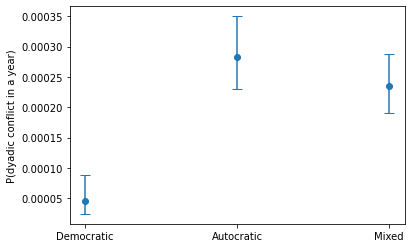

In [100]:
plt.errorbar(
    ["Democratic", "Autocratic", "Mixed"], 
    [estimate_p_dem_dyad, estimate_p_non_dem_dyad, estimate_p_mixed_dyad], # estimates
    yerr=[[error_low_p_dem_dyad, error_low_p_non_dem_dyad, error_low_p_mixed_dyad], # lower
          [error_high_p_dem_dyad, error_high_p_non_dem_dyad, error_high_p_mixed_dyad]], # upper
    fmt='o', 
    capsize=5
)
plt.xticks()
plt.yticks()
plt.ylabel("P(dyadic conflict in a year)")
#plt.show()
plt.savefig("../paper/figures/conflict_probabilities.png")

# Stupid trajectories

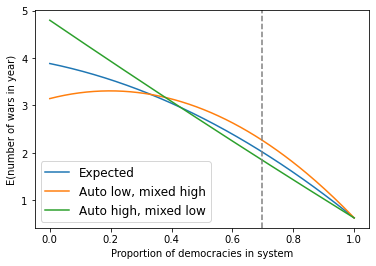

In [102]:
# Up to 1994
# p_dem_conflict = 0.0001347607995807442
# p_non_dem_conflict = 0.0003212107403907566
# p_mixed_conflict = 0.0003395023743947309

def generate_expected_num_conflicts_trajectory(
    current_num_countries, 
    p_dem_conflict, 
    p_non_dem_conflict, 
    p_mixed_conflict
):
    dem_countries = []
    expected_num_conflicts = []
    for num_dem_countries in range(0, current_num_countries+1):
        num_non_dem_countries = current_num_countries - num_dem_countries

        num_dem_dyads = comb(num_dem_countries, 2)
        num_non_dem_dyads = comb(num_non_dem_countries, 2)
        num_mixed_dyads = num_dem_countries * num_non_dem_countries

        expectation = num_dem_dyads * p_dem_conflict + num_non_dem_dyads * p_non_dem_conflict + num_mixed_dyads * p_mixed_conflict

        dem_countries.append(num_dem_countries)
        expected_num_conflicts.append(expectation)
    return (dem_countries, expected_num_conflicts)

dem_countries, expected_num_conflicts = generate_expected_num_conflicts_trajectory(current_num_countries, estimate_p_dem_dyad, estimate_p_non_dem_dyad, estimate_p_mixed_dyad)
# name order is non-dem, mixed
_, expected_num_conflicts_low_low = generate_expected_num_conflicts_trajectory(current_num_countries, estimate_p_dem_dyad, ci_low_p_non_dem_dyad, ci_low_p_mixed_dyad)
_, expected_num_conflicts_low_high = generate_expected_num_conflicts_trajectory(current_num_countries, estimate_p_dem_dyad, ci_low_p_non_dem_dyad, ci_high_p_mixed_dyad)
_, expected_num_conflicts_high_low = generate_expected_num_conflicts_trajectory(current_num_countries, estimate_p_dem_dyad, ci_high_p_non_dem_dyad, ci_low_p_mixed_dyad)
_, expected_num_conflicts_high_high = generate_expected_num_conflicts_trajectory(current_num_countries, estimate_p_dem_dyad, ci_high_p_non_dem_dyad, ci_high_p_mixed_dyad)

dem_countries = [i/current_num_countries for i in dem_countries] # turn to proportion
plt.plot(dem_countries, expected_num_conflicts, label="Expected")
#plt.plot(dem_countries, expected_num_conflicts_low_low)
plt.plot(dem_countries, expected_num_conflicts_low_high, label="Auto low, mixed high")
plt.plot(dem_countries, expected_num_conflicts_high_low, label="Auto high, mixed low")
#plt.plot(dem_countries, expected_num_conflicts_high_high)
plt.axvline(x=current_num_dem_countries/current_num_countries, color='grey', ls='--')
plt.legend(fontsize=12)
plt.xlabel("Proportion of democracies in system")
plt.ylabel("E(number of wars in year)")
plt.xticks()
plt.yticks()
plt.savefig("../paper/figures/empirical_trajectories.png")

# Three regime types

In [164]:
democ_threshold = 5
auto_threshold = -5

def num_democracies(democ_threshold, year):
    return len(pdf[(pdf.year == year) & (pdf.polity > democ_threshold)])

def num_anocracies(democ_threshold, auto_threshold, year):
    return len(pdf[(pdf.year == year) & (pdf.polity <= democ_threshold) & (pdf.polity >= auto_threshold)])

def num_autocracies(auto_threshold, year):
    return len(pdf[(pdf.year == year) & (pdf.polity < auto_threshold)])

def num_conflict_dem_dyad(democ_threshold, auto_threshold, year=None):
    if year == None:
        return len(ddf.loc[(ddf.polity_x > democ_threshold) & (ddf.polity_y > democ_threshold)])
    else:
        return len(ddf.loc[(ddf.polity_x > democ_threshold) & (ddf.polity_y > democ_threshold) & (ddf.year == year)])

def num_conflict_auto_dyad(democ_threshold, auto_threshold, year=None):
    if year == None:
        return len(ddf.loc[(ddf.polity_x < auto_threshold) & (ddf.polity_y < auto_threshold)])
    else:
        return len(ddf.loc[(ddf.polity_x < auto_threshold) & (ddf.polity_y < auto_threshold) & (ddf.year == year)])
    
def num_conflict_anoc_dyad(democ_threshold, auto_threshold, year=None):
    if year == None:
        return len(ddf.loc[((ddf.polity_x >= auto_threshold) & (ddf.polity_x <= democ_threshold)) & ((ddf.polity_y >= auto_threshold) & (ddf.polity_y <= democ_threshold))])
    else:
        return len(ddf.loc[((ddf.polity_x >= auto_threshold) & (ddf.polity_x <= democ_threshold)) & ((ddf.polity_y >= auto_threshold) & (ddf.polity_y <= democ_threshold)) & (ddf.year == year)])

def num_conflict_dem_anoc_dyad(democ_threshold, auto_threshold, year=None):
    if year == None:
        return len(ddf.loc[((ddf.polity_x > democ_threshold) & ((ddf.polity_y >= auto_threshold) & (ddf.polity_y <= democ_threshold))) | ((ddf.polity_y > democ_threshold) & ((ddf.polity_x >= auto_threshold) & (ddf.polity_x <= democ_threshold)))])
    else:
        return len(ddf.loc[((ddf.polity_x > democ_threshold) & ((ddf.polity_y >= auto_threshold) & (ddf.polity_y <= democ_threshold))) | ((ddf.polity_y > democ_threshold) & ((ddf.polity_x >= auto_threshold) & (ddf.polity_x <= democ_threshold))) & (ddf.year == year)])

def num_conflict_dem_auto_dyad(democ_threshold, auto_threshold, year=None):
    if year == None:
        return len(ddf.loc[((ddf.polity_x > democ_threshold) & (ddf.polity_y < auto_threshold)) | ((ddf.polity_y > democ_threshold) & (ddf.polity_x < auto_threshold))])
    else:
        return len(ddf.loc[((ddf.polity_x > democ_threshold) & (ddf.polity_y < auto_threshold)) | ((ddf.polity_y > democ_threshold) & (ddf.polity_x < auto_threshold)) & (ddf.year == year)])

def num_conflict_auto_anoc_dyad(democ_threshold, auto_threshold, year=None):
    if year == None:
        return len(ddf.loc[((ddf.polity_x < auto_threshold) & ((ddf.polity_y >= auto_threshold) & (ddf.polity_y <= democ_threshold))) | ((ddf.polity_y < auto_threshold) & ((ddf.polity_x >= auto_threshold) & (ddf.polity_x <= democ_threshold)))])
    else:
        return len(ddf.loc[((ddf.polity_x < auto_threshold) & ((ddf.polity_y >= auto_threshold) & (ddf.polity_y <= democ_threshold))) | ((ddf.polity_y < auto_threshold) & ((ddf.polity_x >= auto_threshold) & (ddf.polity_x <= democ_threshold))) & (ddf.year == year)])


    
def num_dem_dyad(democ_threshold, auto_threshold, year=None):
    if year == None:
        return len(dpdf.loc[(dpdf.polity_x > democ_threshold) & (dpdf.polity_y > democ_threshold)])
    else:
        return len(dpdf.loc[(dpdf.polity_x > democ_threshold) & (dpdf.polity_y > democ_threshold) & (dpdf.year == year)])

def num_auto_dyad(democ_threshold, auto_threshold, year=None):
    if year == None:
        return len(dpdf.loc[(dpdf.polity_x < auto_threshold) & (dpdf.polity_y < auto_threshold)])
    else:
        return len(dpdf.loc[(dpdf.polity_x < auto_threshold) & (dpdf.polity_y < auto_threshold) & (dpdf.year == year)])
    
def num_anoc_dyad(democ_threshold, auto_threshold, year=None):
    if year == None:
        return len(dpdf.loc[((dpdf.polity_x >= auto_threshold) & (dpdf.polity_x <= democ_threshold)) & ((dpdf.polity_y >= auto_threshold) & (dpdf.polity_y <= democ_threshold))])
    else:
        return len(dpdf.loc[((dpdf.polity_x >= auto_threshold) & (dpdf.polity_x <= democ_threshold)) & ((dpdf.polity_y >= auto_threshold) & (dpdf.polity_y <= democ_threshold)) & (dpdf.year == year)])

def num_dem_anoc_dyad(democ_threshold, auto_threshold, year=None):
    if year == None:
        return len(dpdf.loc[((dpdf.polity_x > democ_threshold) & ((dpdf.polity_y >= auto_threshold) & (dpdf.polity_y <= democ_threshold))) | ((dpdf.polity_y > democ_threshold) & ((dpdf.polity_x >= auto_threshold) & (dpdf.polity_x <= democ_threshold)))])
    else:
        return len(dpdf.loc[((dpdf.polity_x > democ_threshold) & ((dpdf.polity_y >= auto_threshold) & (dpdf.polity_y <= democ_threshold))) | ((dpdf.polity_y > democ_threshold) & ((dpdf.polity_x >= auto_threshold) & (dpdf.polity_x <= democ_threshold))) & (dpdf.year == year)])

def num_dem_auto_dyad(democ_threshold, auto_threshold, year=None):
    if year == None:
        return len(dpdf.loc[((dpdf.polity_x > democ_threshold) & (dpdf.polity_y < auto_threshold)) | ((dpdf.polity_y > democ_threshold) & (dpdf.polity_x < auto_threshold))])
    else:
        return len(dpdf.loc[((dpdf.polity_x > democ_threshold) & (dpdf.polity_y < auto_threshold)) | ((dpdf.polity_y > democ_threshold) & (dpdf.polity_x < auto_threshold)) & (dpdf.year == year)])

def num_auto_anoc_dyad(democ_threshold, auto_threshold, year=None):
    if year == None:
        return len(dpdf.loc[((dpdf.polity_x < auto_threshold) & ((dpdf.polity_y >= auto_threshold) & (dpdf.polity_y <= democ_threshold))) | ((dpdf.polity_y < auto_threshold) & ((dpdf.polity_x >= auto_threshold) & (dpdf.polity_x <= democ_threshold)))])
    else:
        return len(dpdf.loc[((dpdf.polity_x < auto_threshold) & ((dpdf.polity_y >= auto_threshold) & (dpdf.polity_y <= democ_threshold))) | ((dpdf.polity_y < auto_threshold) & ((dpdf.polity_x >= auto_threshold) & (dpdf.polity_x <= democ_threshold))) & (dpdf.year == year)])



In [167]:
# Sanity check to make sure math works out
print(len(dpdf))

print()

print(num_dem_dyad(democ_threshold, auto_threshold))
print(num_auto_dyad(democ_threshold, auto_threshold))
print(num_anoc_dyad(democ_threshold, auto_threshold))
print(num_dem_anoc_dyad(democ_threshold, auto_threshold))
print(num_dem_auto_dyad(democ_threshold, auto_threshold))
print(num_auto_anoc_dyad(democ_threshold, auto_threshold))

num_dem_dyad(democ_threshold, auto_threshold) + \
num_auto_dyad(democ_threshold, auto_threshold) + \
num_anoc_dyad(democ_threshold, auto_threshold) + \
num_dem_anoc_dyad(democ_threshold, auto_threshold) + \
num_dem_auto_dyad(democ_threshold, auto_threshold) + \
num_auto_anoc_dyad(democ_threshold, auto_threshold)

print()

# Same difference as with two regime types
print(len(ddf))

print()

print(num_conflict_dem_dyad(democ_threshold, auto_threshold))
print(num_conflict_auto_dyad(democ_threshold, auto_threshold))
print(num_conflict_anoc_dyad(democ_threshold, auto_threshold))
print(num_conflict_dem_anoc_dyad(democ_threshold, auto_threshold))
print(num_conflict_dem_auto_dyad(democ_threshold, auto_threshold))
print(num_conflict_auto_anoc_dyad(democ_threshold, auto_threshold))

num_conflict_dem_dyad(democ_threshold, auto_threshold) + \
num_conflict_auto_dyad(democ_threshold, auto_threshold) + \
num_conflict_anoc_dyad(democ_threshold, auto_threshold) + \
num_conflict_dem_anoc_dyad(democ_threshold, auto_threshold) + \
num_conflict_dem_auto_dyad(democ_threshold, auto_threshold) + \
num_conflict_auto_anoc_dyad(democ_threshold, auto_threshold)


881671

131728
122167
99669
184718
175212
168177

194

5
26
25
23
58
48


185

In [168]:
democ_threshold = 5
auto_threshold = -5

estimate_p_dem_dyad = num_conflict_dem_dyad(democ_threshold, auto_threshold)/num_dem_dyad(democ_threshold, auto_threshold)
ci_low_p_dem_dyad, ci_high_p_dem_dyad = smp.proportion_confint(num_conflict_dem_dyad(democ_threshold, auto_threshold), num_dem_dyad(democ_threshold, auto_threshold), method='wilson')
error_low_p_dem_dyad = estimate_p_dem_dyad - ci_low_p_dem_dyad
error_high_p_dem_dyad = ci_high_p_dem_dyad - estimate_p_dem_dyad

print(f"Dem dyad: {estimate_p_dem_dyad:.10f}")
print(f"Dem dyad CI: [{ci_low_p_dem_dyad:.10f}, {ci_high_p_dem_dyad:.10f}]")

estimate_p_auto_dyad = num_conflict_auto_dyad(democ_threshold, auto_threshold)/num_auto_dyad(democ_threshold, auto_threshold)
ci_low_p_auto_dyad, ci_high_p_auto_dyad = smp.proportion_confint(num_conflict_auto_dyad(democ_threshold, auto_threshold), num_auto_dyad(democ_threshold, auto_threshold), method='wilson')
error_low_p_auto_dyad = estimate_p_auto_dyad - ci_low_p_auto_dyad
error_high_p_auto_dyad = ci_high_p_auto_dyad - estimate_p_auto_dyad

print(f"Auto dyad: {estimate_p_auto_dyad:.10f}")
print(f"Auto dyad CI: [{ci_low_p_auto_dyad:.10f}, {ci_high_p_auto_dyad:.10f}]")

estimate_p_anoc_dyad = num_conflict_anoc_dyad(democ_threshold, auto_threshold)/num_anoc_dyad(democ_threshold, auto_threshold)
ci_low_p_anoc_dyad, ci_high_p_anoc_dyad = smp.proportion_confint(num_conflict_anoc_dyad(democ_threshold, auto_threshold), num_anoc_dyad(democ_threshold, auto_threshold), method='wilson')
error_low_p_anoc_dyad = estimate_p_anoc_dyad - ci_low_p_anoc_dyad
error_high_p_anoc_dyad = ci_high_p_anoc_dyad - estimate_p_anoc_dyad

print(f"Anoc dyad: {estimate_p_mixed_dyad:.10f}")
print(f"Anoc dyad CI: [{ci_low_p_mixed_dyad:.10f}, {ci_high_p_mixed_dyad:.10f}]")

estimate_p_dem_auto_dyad = num_conflict_dem_auto_dyad(democ_threshold, auto_threshold)/num_dem_auto_dyad(democ_threshold, auto_threshold)
ci_low_p_dem_auto_dyad, ci_high_p_dem_auto_dyad = smp.proportion_confint(num_conflict_dem_auto_dyad(democ_threshold, auto_threshold), num_dem_auto_dyad(democ_threshold, auto_threshold), method='wilson')
error_low_p_dem_auto_dyad = estimate_p_dem_auto_dyad - ci_low_p_dem_auto_dyad
error_high_p_dem_auto_dyad = ci_high_p_dem_auto_dyad - estimate_p_dem_auto_dyad

print(f"Dem-auto dyad: {estimate_p_dem_auto_dyad:.10f}")
print(f"Dem-auto dyad CI: [{ci_low_p_dem_auto_dyad:.10f}, {ci_high_p_dem_auto_dyad:.10f}]")

estimate_p_dem_anoc_dyad = num_conflict_dem_anoc_dyad(democ_threshold, auto_threshold)/num_dem_anoc_dyad(democ_threshold, auto_threshold)
ci_low_p_dem_anoc_dyad, ci_high_p_dem_anoc_dyad = smp.proportion_confint(num_conflict_dem_anoc_dyad(democ_threshold, auto_threshold), num_dem_anoc_dyad(democ_threshold, auto_threshold), method='wilson')
error_low_p_dem_anoc_dyad = estimate_p_dem_anoc_dyad - ci_low_p_dem_anoc_dyad
error_high_p_dem_anoc_dyad = ci_high_p_dem_anoc_dyad - estimate_p_dem_anoc_dyad

print(f"Dem-anoc dyad: {estimate_p_dem_anoc_dyad:.10f}")
print(f"Dem-anoc dyad CI: [{ci_low_p_dem_anoc_dyad:.10f}, {ci_high_p_dem_anoc_dyad:.10f}]")

estimate_p_auto_anoc_dyad = num_conflict_auto_anoc_dyad(democ_threshold, auto_threshold)/num_auto_anoc_dyad(democ_threshold, auto_threshold)
ci_low_p_auto_anoc_dyad, ci_high_p_auto_anoc_dyad = smp.proportion_confint(num_conflict_auto_anoc_dyad(democ_threshold, auto_threshold), num_auto_anoc_dyad(democ_threshold, auto_threshold), method='wilson')
error_low_p_auto_anoc_dyad = estimate_p_auto_anoc_dyad - ci_low_p_auto_anoc_dyad
error_high_p_auto_anoc_dyad = ci_high_p_auto_anoc_dyad - estimate_p_auto_anoc_dyad

print(f"Auto-anoc dyad: {estimate_p_auto_anoc_dyad:.10f}")
print(f"Auto-anoc dyad CI: [{ci_low_p_auto_anoc_dyad:.10f}, {ci_high_p_auto_anoc_dyad:.10f}]")


Dem dyad: 0.0000379570
Dem dyad CI: [0.0000162131, 0.0000888599]
Auto dyad: 0.0002128234
Auto dyad CI: [0.0001452473, 0.0003118296]
Anoc dyad: 0.0002349054
Anoc dyad CI: [0.0001911330, 0.0002886993]
Dem-auto dyad: 0.0003310276
Dem-auto dyad CI: [0.0002561039, 0.0004278608]
Dem-anoc dyad: 0.0001245141
Dem-anoc dyad CI: [0.0000829756, 0.0001868433]
Auto-anoc dyad: 0.0002854136
Auto-anoc dyad CI: [0.0002152947, 0.0003783606]


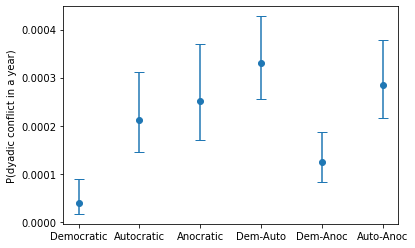

In [169]:
plt.errorbar(
    ["Democratic", "Autocratic", "Anocratic", "Dem-Auto", "Dem-Anoc", "Auto-Anoc"], 
    [estimate_p_dem_dyad, estimate_p_auto_dyad, estimate_p_anoc_dyad, estimate_p_dem_auto_dyad, estimate_p_dem_anoc_dyad, estimate_p_auto_anoc_dyad], # estimates
    yerr=[[error_low_p_dem_dyad, error_low_p_auto_dyad, error_low_p_anoc_dyad, error_low_p_dem_auto_dyad, error_low_p_dem_anoc_dyad, error_low_p_auto_anoc_dyad], # lower
          [error_high_p_dem_dyad, error_high_p_auto_dyad, error_high_p_anoc_dyad, error_high_p_dem_auto_dyad, error_high_p_dem_anoc_dyad, error_high_p_auto_anoc_dyad]], # upper
    fmt='o', 
    capsize=5
)
plt.xticks()
plt.yticks()
plt.ylabel("P(dyadic conflict in a year)")
#plt.show()
plt.savefig("../paper/figures/conflict_probabilities_three_regime_types.png")

166
0
21
166
1
21
166
2
21
166
3
21
166
4
21
166
5
21
166
6
21
166
7
21
166
8
21
166
9
21
166
10
21
166
11
21
166
12
21
166
13
21
166
14
21
166
15
21
166
16
21
166
17
21
166
18
21
166
19
21
166
20
21
166
21
21
166
22
21
166
23
21
166
24
21
166
25
21
166
26
21
166
27
21
166
28
21
166
29
21
166
30
21
166
31
21
166
32
21
166
33
21
166
34
21
166
35
21
166
36
21
166
37
21
166
38
21
166
39
21
166
40
21
166
41
21
166
42
21
166
43
21
166
44
21
166
45
21
166
46
21
166
47
21
166
48
21
166
49
21
166
50
21
166
51
21
166
52
21
166
53
21
166
54
21
166
55
21
166
56
21
166
57
21
166
58
21
166
59
21
166
60
21
166
61
21
166
62
21
166
63
21
166
64
21
166
65
21
166
66
21
166
67
21
166
68
21
166
69
21
166
70
21
166
71
21
166
72
21
166
73
21
166
74
21
166
75
21
166
76
21
166
77
21
166
78
21
166
79
21
166
80
21
166
81
21
166
82
21
166
83
21
166
84
21
166
85
21
166
86
21
166
87
21
166
88
21
166
89
21
166
90
21
166
91
21
166
92
21
166
93
21
166
94
21
166
95
21
166
96
21
166
97
21
166
98
21
166
99
21
166
100
21

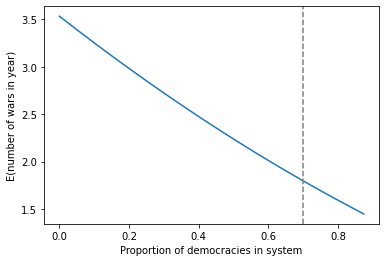

In [177]:
num_auto_countries = 21

def generate_expected_num_conflicts_trajectory_three(
    current_num_countries, 
    p_dem_conflict, 
    p_auto_conflict, 
    p_anoc_conflict,
    p_dem_auto_conflict,
    p_dem_anoc_conflict,
    p_auto_anoc_conflict
):
    dem_countries = []
    expected_num_conflicts = []
    for num_dem_countries in range(0, current_num_countries+1-num_auto_countries):
        print(current_num_countries)
        print(num_dem_countries)
        print(num_auto_countries)

        num_anoc_countries = current_num_countries - num_dem_countries - num_auto_countries

        num_dem_dyads = comb(num_dem_countries, 2)
        num_auto_dyads = comb(num_auto_countries, 2)
        num_anoc_dyads = comb(num_anoc_countries, 2)
        num_dem_auto_dyads = num_dem_countries * num_auto_countries
        num_dem_anoc_dyads = num_dem_countries * num_anoc_countries
        num_auto_anoc_dyads = num_auto_countries * num_anoc_countries

        expectation = num_dem_dyads * p_dem_conflict + \
        num_auto_dyads * p_auto_conflict + \
        num_anoc_dyads * p_anoc_conflict + \
        num_dem_auto_dyads * p_dem_auto_conflict + \
        num_dem_anoc_dyads * p_dem_anoc_conflict + \
        num_auto_anoc_dyads * p_auto_anoc_conflict

        dem_countries.append(num_dem_countries)
        expected_num_conflicts.append(expectation)
    return (dem_countries, expected_num_conflicts)

dem_countries, expected_num_conflicts = generate_expected_num_conflicts_trajectory_three(
    current_num_countries, 
    estimate_p_dem_dyad, 
    estimate_p_auto_dyad, 
    estimate_p_anoc_dyad,
    estimate_p_dem_auto_dyad, 
    estimate_p_dem_anoc_dyad, 
    estimate_p_auto_anoc_dyad
)

dem_countries = [i/current_num_countries for i in dem_countries] # turn to proportion

plt.plot(dem_countries, expected_num_conflicts)
plt.axvline(x=current_num_dem_countries/current_num_countries, color='grey', ls='--')
plt.xlabel("Proportion of democracies in system")
plt.ylabel("E(number of wars in year)")
plt.xticks()
plt.yticks()
plt.savefig("../paper/figures/empirical_trajectories_three.png")

# Conflict rates over time

In [108]:
years = list(pdf.year.unique())

In [109]:
threshold = 2
d = {}
for year in years:
    d[year] = {}
    d[year]['num_dem'] = num_democracies(threshold, year)
    d[year]['num_non_dem'] = num_non_democracies(threshold, year)
    d[year]['num_dem_dyad'] = num_dem_dyad(threshold, year)
    d[year]['num_non_dem_dyad'] = num_non_dem_dyad(threshold, year)
    d[year]['num_mixed_dyad'] = num_mixed_dyad(threshold, year)
    d[year]['num_conflict_dem_dyad'] = num_conflict_dem_dyad(threshold, year)
    d[year]['num_conflict_non_dem_dyad'] = num_conflict_non_dem_dyad(threshold, year)
    d[year]['num_conflict_mixed_dyad'] = num_conflict_mixed_dyad(threshold, year)

In [110]:
dem_props = []
num_conflicts = []
num_dem_conflicts = []
num_non_dem_conflicts = []
num_mixed_conflicts = []

for k, v in d.items():
    dem_props.append(v['num_dem']/(v['num_dem'] + v['num_non_dem']))
    num_conflicts.append(v['num_conflict_dem_dyad'] + v['num_conflict_non_dem_dyad'] + v['num_conflict_mixed_dyad'])
    num_dem_conflicts.append(v['num_conflict_dem_dyad'])
    num_non_dem_conflicts.append(v['num_conflict_non_dem_dyad'])
    num_mixed_conflicts.append(v['num_conflict_mixed_dyad'])


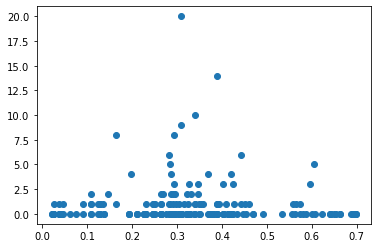

In [111]:
plt.scatter(dem_props, num_conflicts)

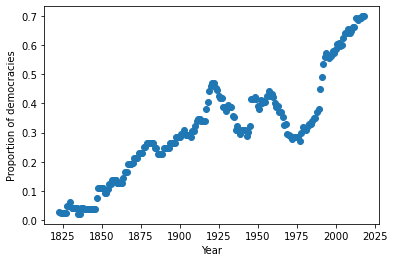

In [113]:
plt.scatter(years, dem_props)
plt.xlabel("Year")
plt.ylabel("Proportion of democracies")
plt.show()

1.0125171620207933
0.004269540249152314


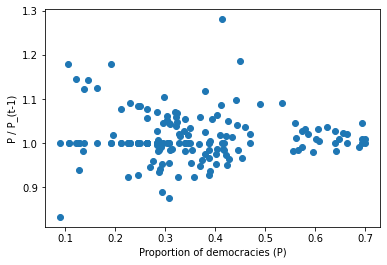

In [136]:
percent_changes = []
trimmed_dem_props = []
for k, v in d.items():
    if (k < 1850): # Exclude years w < 10% dem
        continue
    
    trimmed_dem_props.append(v['num_dem']/(v['num_dem'] + v['num_non_dem']))
    
    old_prop = d[k-1]['num_dem']/(d[k-1]['num_dem'] + d[k-1]['num_non_dem'])
    
    percent_changes.append((v['num_dem']/(v['num_dem'] + v['num_non_dem']))/old_prop)

print(np.mean(percent_changes))
print(stats.sem(percent_changes))

plt.scatter(trimmed_dem_props, percent_changes)
plt.xlabel("Proportion of democracies (P)")
plt.ylabel("P / P_(t-1)")
plt.show()

(array([  1.,   1.,  14., 164.,   9.,   2.,   1.,   0.,   0.,   3.]),
 array([0.5 , 0.65, 0.8 , 0.95, 1.1 , 1.25, 1.4 , 1.55, 1.7 , 1.85, 2.  ]),
 <BarContainer object of 10 artists>)

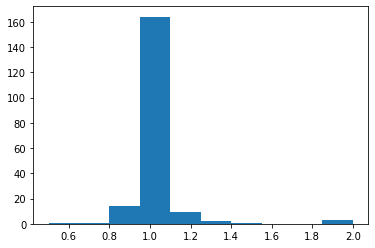

In [132]:
plt.hist(percent_changes)

In [83]:
dem_props = []
num_conflicts = []
num_dem_conflicts = []
num_non_dem_conflicts = []
num_mixed_conflicts = []

for year_group in [years[i:i+10] for i in range(0, len(years), 10)]:
    dem_prop_num = 0
    dem_prop_denom = 0
    num_conflict = 0
    num_dem_conflict = 0
    num_non_dem_conflict = 0
    num_mixed_conflict = 0
    for year in year_group:
        v = d[year]
        dem_prop_num += v['num_dem']
        dem_prop_denom += v['num_dem'] + v['num_non_dem']
        num_conflict += v['num_conflict_dem_dyad'] + v['num_conflict_non_dem_dyad'] + v['num_conflict_mixed_dyad']
        num_dem_conflict += v['num_conflict_dem_dyad']
        num_non_dem_conflict += v['num_conflict_non_dem_dyad']
        num_mixed_conflict += v['num_conflict_mixed_dyad']

    dem_props.append(dem_prop_num/dem_prop_denom)
    num_conflicts.append(num_conflict)
    num_dem_conflicts.append(num_dem_conflict)
    num_non_dem_conflicts.append(num_non_dem_conflict)
    num_mixed_conflicts.append(num_mixed_conflict)


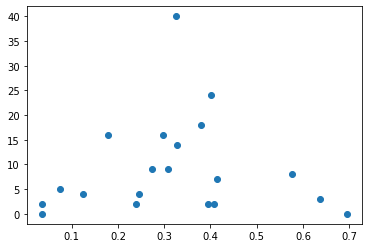

In [84]:
plt.scatter(dem_props, num_conflicts)

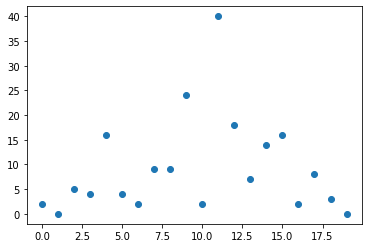

In [85]:
plt.scatter(range(0, len([years[i:i+10] for i in range(0, len(years), 10)])), num_conflicts)    

# Trajectories with weighting

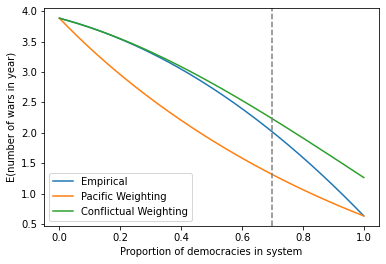

In [135]:
def generate_expected_num_conflicts_trajectory_pacifying_non_dem(
    current_num_countries, 
    p_dem_conflict, 
    p_non_dem_conflict, 
    p_mixed_conflict,
    weighting_strat = 'linear'
):
    dem_countries = []
    expected_num_conflicts = []
    
    for num_dem_countries in range(0, current_num_countries+1):
        if weighting_strat == 'linear':
            weighted_p_non_dem_conflict = p_non_dem_conflict * (1-(num_dem_countries/current_num_countries))
            weighted_p_mixed_conflict = p_mixed_conflict * (1-(num_dem_countries/current_num_countries))
        elif weighting_strat == 'inverse':
            # https://math.stackexchange.com/questions/57429/functions-similar-to-log-but-with-results-between-0-and-1
            weighted_p_non_dem_conflict = p_non_dem_conflict * 1/(1+(num_dem_countries/current_num_countries))
            weighted_p_mixed_conflict = p_mixed_conflict * 1/(1+(num_dem_countries/current_num_countries))
        else:
            raise RuntimeError
        
        num_non_dem_countries = current_num_countries - num_dem_countries

        num_dem_dyads = comb(num_dem_countries, 2)
        num_non_dem_dyads = comb(num_non_dem_countries, 2)
        num_mixed_dyads = num_dem_countries * num_non_dem_countries

        expectation = num_dem_dyads * p_dem_conflict + num_non_dem_dyads * weighted_p_non_dem_conflict + num_mixed_dyads * weighted_p_mixed_conflict

        dem_countries.append(num_dem_countries)
        expected_num_conflicts.append(expectation)
    return (dem_countries, expected_num_conflicts)

def generate_expected_num_conflicts_trajectory_dem_conflictual(
    current_num_countries, 
    p_dem_conflict, 
    p_non_dem_conflict, 
    p_mixed_conflict,
    weighting_strat = 'linear'
):
    dem_countries = []
    expected_num_conflicts = []
    
    for num_dem_countries in range(0, current_num_countries+1):
        if weighting_strat == 'linear':
            weighted_p_dem_conflict = p_dem_conflict * (1+(num_dem_countries/current_num_countries))
        elif weighting_strat == 'exp':
            weighted_p_dem_conflict = p_dem_conflict * 3 ** (num_dem_countries/current_num_countries)
        else:
            raise RuntimeError
        
        num_non_dem_countries = current_num_countries - num_dem_countries

        num_dem_dyads = comb(num_dem_countries, 2)
        num_non_dem_dyads = comb(num_non_dem_countries, 2)
        num_mixed_dyads = num_dem_countries * num_non_dem_countries

        expectation = num_dem_dyads * weighted_p_dem_conflict + num_non_dem_dyads * p_non_dem_conflict + num_mixed_dyads * p_mixed_conflict

        dem_countries.append(num_dem_countries)
        expected_num_conflicts.append(expectation)
    return (dem_countries, expected_num_conflicts)

dem_countries, expected_num_conflicts = generate_expected_num_conflicts_trajectory(current_num_countries, estimate_p_dem_dyad, estimate_p_non_dem_dyad, estimate_p_mixed_dyad)
_, weighted_linear_expected_num_conflicts = generate_expected_num_conflicts_trajectory_pacifying_non_dem(
    current_num_countries, 
    estimate_p_dem_dyad, 
    estimate_p_non_dem_dyad, 
    estimate_p_mixed_dyad
)
_, weighted_inverse_expected_num_conflicts = generate_expected_num_conflicts_trajectory_pacifying_non_dem(
    current_num_countries, 
    estimate_p_dem_dyad, 
    estimate_p_non_dem_dyad, 
    estimate_p_mixed_dyad,
    weighting_strat='inverse'
)

dem_countries = [i/current_num_countries for i in dem_countries] # turn to proportion
plt.plot(dem_countries, expected_num_conflicts, label="Empirical")
#plt.plot(dem_countries, weighted_linear_expected_num_conflicts, label="Expected Weighted Linear")
plt.plot(dem_countries, weighted_inverse_expected_num_conflicts, label="Pacific Weighting")
plt.plot(dem_countries, weighted_conflictual_linear_expected_num_conflicts, label="Conflictual Weighting")

plt.axvline(x=current_num_dem_countries/current_num_countries, color='grey', ls='--')
plt.xlabel("Proportion of democracies in system")
plt.ylabel("E(number of wars in year)")
plt.xticks()
plt.yticks()
plt.legend(loc='lower left')
plt.savefig("../paper/figures/weighted_trajectories.png")

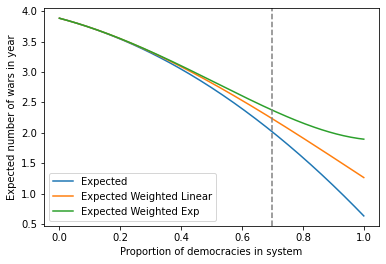

In [136]:
dem_countries, expected_num_conflicts = generate_expected_num_conflicts_trajectory(current_num_countries, estimate_p_dem_dyad, estimate_p_non_dem_dyad, estimate_p_mixed_dyad)
_, weighted_conflictual_linear_expected_num_conflicts = generate_expected_num_conflicts_trajectory_dem_conflictual(
    current_num_countries, 
    estimate_p_dem_dyad, 
    estimate_p_non_dem_dyad, 
    estimate_p_mixed_dyad
)
_, weighted_exp_expected_num_conflicts = generate_expected_num_conflicts_trajectory_dem_conflictual(
    current_num_countries, 
    estimate_p_dem_dyad, 
    estimate_p_non_dem_dyad, 
    estimate_p_mixed_dyad,
    weighting_strat='exp'
)

dem_countries = [i/current_num_countries for i in dem_countries] # turn to proportion
plt.plot(dem_countries, expected_num_conflicts, label="Expected")
plt.plot(dem_countries, weighted_conflictual_linear_expected_num_conflicts, label="Expected Weighted Linear")
plt.plot(dem_countries, weighted_exp_expected_num_conflicts, label="Expected Weighted Exp")

plt.axvline(x=current_num_dem_countries/current_num_countries, color='grey', ls='--')
plt.legend()
plt.xlabel("Proportion of democracies in system")
plt.ylabel("Expected number of wars in year")
plt.show()

In [268]:


np.ones(9)
np.zeros(195251)
a = np.concatenate([np.ones(9), np.zeros(195251)])
n = 195251 + 9
p_hat = 9/n

print(n)
#print(f"{9/n:.20f}")
#print(f"{np.var(a):.20f}")
print(f"{np.mean(a):.20f}")
print(f"{np.sqrt((p_hat * (1-p_hat))/n):.20f}") # std error
print(f"{1.96*np.sqrt((p_hat * (1-p_hat))/n):.20f}") # 95% conf interval

lower, upper = smp.proportion_confint(9, n, method='wilson')
printf(lower)
printf(upper)

195251
9
195260
0.00004609238963433371
0.00001536377578930062
0.00003011300054702922
0.00002425028074083058
0.00008760585533390850


# Contiguity

## Summary

In [107]:
# If I weren't so lazy these should not be repeated
def num_contig_conflict_dem_dyad(threshold, year=None):
    if year == None:
        return len(contigconflictdf.loc[(contigconflictdf.polity_x > threshold) & (contigconflictdf.polity_y > threshold)])
    else:
        return len(contigconflictdf.loc[(contigconflictdf.polity_x > threshold) & (contigconflictdf.polity_y > threshold) & (contigconflictdf.year == year)])
    
def num_contig_conflict_non_dem_dyad(threshold, year=None):
    if year == None:
        return len(contigconflictdf.loc[(contigconflictdf.polity_x <= threshold) & (contigconflictdf.polity_y <= threshold)])
    else:
        return len(contigconflictdf.loc[(contigconflictdf.polity_x <= threshold) & (contigconflictdf.polity_y <= threshold) & (contigconflictdf.year == year)])

def num_contig_conflict_mixed_dyad(threshold, year=None):
    if year == None:
        return len(contigconflictdf.loc[(contigconflictdf.polity_x > threshold) ^ (contigconflictdf.polity_y > threshold)])
    else:
        return len(contigconflictdf.loc[((contigconflictdf.polity_x > threshold) ^ (contigconflictdf.polity_y > threshold)) & (contigconflictdf.year == year)])
    
def num_contig_dem_dyad(threshold, year=None):
    if year == None:
        return len(undirectedcontigdf.loc[(undirectedcontigdf.polity_x > threshold) & (undirectedcontigdf.polity_y > threshold)])
    else:
        return len(undirectedcontigdf.loc[(undirectedcontigdf.polity_x > threshold) & (undirectedcontigdf.polity_y > threshold) & (undirectedcontigdf.year == year)])
    
def num_contig_non_dem_dyad(threshold, year=None):
    if year == None:
        return len(undirectedcontigdf.loc[(undirectedcontigdf.polity_x <= threshold) & (undirectedcontigdf.polity_y <= threshold)])
    else:
        return len(undirectedcontigdf.loc[(undirectedcontigdf.polity_x <= threshold) & (undirectedcontigdf.polity_y <= threshold) & (undirectedcontigdf.year == year)])

def num_contig_mixed_dyad(threshold, year=None):
    if year == None:
        return len(undirectedcontigdf.loc[(undirectedcontigdf.polity_x > threshold) ^ (undirectedcontigdf.polity_y > threshold)])
    else:
        return len(undirectedcontigdf.loc[((undirectedcontigdf.polity_x > threshold) ^ (undirectedcontigdf.polity_y > threshold)) & (undirectedcontigdf.year == year)])


In [108]:
dem_thres = 2

print(f"Average num neighbors: {np.mean(directedcontigdf.groupby(['state1no', 'year']).size())}")
print(f"Number of contiguous dyad-years: {len(undirectedcontigdf.index)}")

# print(f"Number of dyad-years w/ dem dyad: {len(dpdf.loc[(dpdf.polity_x > dem_thres) & (dpdf.polity_y > dem_thres)])}")
# print(f"Number of dyad-years w/ auto dyad: {len(dpdf.loc[(dpdf.polity_x <= dem_thres) & (dpdf.polity_y <= dem_thres)])}")
# print(f"Number of dyad-years w/ mixed dyad: {len(dpdf.loc[(dpdf.polity_x > dem_thres) ^ (dpdf.polity_y > dem_thres)])}")

print()
print(f"Number of conflictual contiguous dyad-years: {len(contigconflictdf.index)}")
print(f"Number of conflictual contiguous dyad-years w/ dem dyad: {len(contigconflictdf.loc[(contigconflictdf.polity_x > dem_thres) & (contigconflictdf.polity_y > dem_thres)])}")
print(f"Number of conflictual contiguous dyad-years w/ auto dyad: {len(contigconflictdf.loc[(contigconflictdf.polity_x <= dem_thres) & (contigconflictdf.polity_y <= dem_thres)])}")
print(f"Number of conflictual contiguous dyad-years w/ mixed dyad: {len(contigconflictdf.loc[((contigconflictdf.polity_x > dem_thres) ^ (contigconflictdf.polity_y > dem_thres))])}")

print()
print(f"Prob of contiguous conflict in given year: {len(contigconflictdf.index)/len(undirectedcontigdf.index)}")
print(f"Conditional prob of contiguous conflict in given year given dem dyad: {len(contigconflictdf.loc[(contigconflictdf.polity_x > dem_thres) & (contigconflictdf.polity_y > dem_thres)])/len(undirectedcontigdf.loc[(undirectedcontigdf.polity_x > dem_thres) & (undirectedcontigdf.polity_y > dem_thres)])}")
print(f"Condititonal prob of contiguous conflict in given year given non-dem dyad: {len(contigconflictdf.loc[(contigconflictdf.polity_x <= dem_thres) & (contigconflictdf.polity_y <= dem_thres)])/len(undirectedcontigdf.loc[(undirectedcontigdf.polity_x <= dem_thres) & (undirectedcontigdf.polity_y <= dem_thres)])}")
print(f"Conditional prob of contiguous conflict in given year for mixed dyad: {len(contigconflictdf.loc[((contigconflictdf.polity_x > dem_thres) ^ (contigconflictdf.polity_y > dem_thres))])/len(undirectedcontigdf.loc[(undirectedcontigdf.polity_x > dem_thres) ^ (undirectedcontigdf.polity_y > dem_thres)])}")

Average num neighbors: 3.633016627078385
Number of contiguous dyad-years: 20576

Number of conflictual contiguous dyad-years: 79
Number of conflictual contiguous dyad-years w/ dem dyad: 4
Number of conflictual contiguous dyad-years w/ auto dyad: 48
Number of conflictual contiguous dyad-years w/ mixed dyad: 27

Prob of contiguous conflict in given year: 0.0038394245723172627
Conditional prob of contiguous conflict in given year given dem dyad: 0.0008312551953449709
Condititonal prob of contiguous conflict in given year given non-dem dyad: 0.004748713889988128
Conditional prob of contiguous conflict in given year for mixed dyad: 0.004773691654879774


In [109]:
def get_counts_dem(s):
    return s.map(lambda x: int(x > dem_thres)).sum()
def get_counts_auto(s):
    return s.map(lambda x: int(x <= dem_thres)).sum()

# tmp = directedcontigpoldf
# tmp['dem_dem'] = tmp.apply(lambda x: int((x.polity_x > dem_thres) & (x.polity_y > dem_thres)), axis=1)
# tmp['dem_auto'] = tmp.apply(lambda x: int((x.polity_x > dem_thres) & (x.polity_y <= dem_thres)), axis=1)
# tmp['auto_dem'] = tmp.apply(lambda x: int((x.polity_x <= dem_thres) & (x.polity_y > dem_thres)), axis=1)
# tmp['auto_auto'] = tmp.apply(lambda x: int((x.polity_x <= dem_thres) & (x.polity_y <= dem_thres)), axis=1)


print(f"Expected num neighbors for dem: {np.mean(directedcontigpoldf[directedcontigpoldf.polity_x > dem_thres].groupby(['ccode_x', 'year']).size())}")

tmp = directedcontigpoldf[directedcontigpoldf.polity_x > dem_thres].groupby(['ccode_x', 'year']).agg({'polity_x': ['count'], 'polity_y': [get_counts_dem]})
print(f"Expected num dem neighbors for dem: {tmp.polity_y['get_counts_dem'].sum()/len(tmp.index)}")

tmp = directedcontigpoldf[directedcontigpoldf.polity_x > dem_thres].groupby(['ccode_x', 'year']).agg({'polity_x': ['count'], 'polity_y': [get_counts_auto]})
print(f"Expected num auto neighbors for dem: {tmp.polity_y['get_counts_auto'].sum()/len(tmp.index)}")

print(f"Expected num neighbors for auto: {np.mean(directedcontigpoldf[directedcontigpoldf.polity_x <= dem_thres].groupby(['ccode_x', 'year']).size())}")

tmp = directedcontigpoldf[directedcontigpoldf.polity_x <= dem_thres].groupby(['ccode_x', 'year']).agg({'polity_x': ['count'], 'polity_y': [get_counts_dem]})
print(f"Expected num dem neighbors for auto: {tmp.polity_y['get_counts_dem'].sum()/len(tmp.index)}")

tmp = directedcontigpoldf[directedcontigpoldf.polity_x <= dem_thres].groupby(['ccode_x', 'year']).agg({'polity_x': ['count'], 'polity_y': [get_counts_auto]})
print(f"Expected num auto neighbors for auto: {tmp.polity_y['get_counts_auto'].sum()/len(tmp.index)}")


Expected num neighbors for dem: 3.267051528757751
Expected num dem neighbors for dem: 2.057729313662604
Expected num auto neighbors for dem: 1.2093222150951464
Expected num neighbors for auto: 3.363494539781591
Expected num dem neighbors for auto: 0.735309412376495
Expected num auto neighbors for auto: 2.628185127405096


In [110]:
# If I weren't so lazy these should not be repeated
threshold = 2

estimate_contig_p_dem_dyad = num_contig_conflict_dem_dyad(threshold)/num_contig_dem_dyad(threshold)
ci_low_contig_p_dem_dyad, ci_high_contig_p_dem_dyad = smp.proportion_confint(num_contig_conflict_dem_dyad(threshold), num_contig_dem_dyad(threshold), method='wilson')
error_low_contig_p_dem_dyad = estimate_contig_p_dem_dyad - ci_low_contig_p_dem_dyad
error_high_contig_p_dem_dyad = ci_high_contig_p_dem_dyad - estimate_contig_p_dem_dyad

print(f"Dem dyad: {estimate_contig_p_dem_dyad:.10f}")
print(f"Dem dyad CI: [{ci_low_contig_p_dem_dyad:.10f}, {ci_high_contig_p_dem_dyad:.10f}]")

estimate_contig_p_non_dem_dyad = num_contig_conflict_non_dem_dyad(threshold)/num_contig_non_dem_dyad(threshold)
ci_low_contig_p_non_dem_dyad, ci_high_contig_p_non_dem_dyad = smp.proportion_confint(num_contig_conflict_non_dem_dyad(threshold), num_contig_non_dem_dyad(threshold), method='wilson')
error_low_contig_p_non_dem_dyad = estimate_contig_p_non_dem_dyad - ci_low_contig_p_non_dem_dyad
error_high_contig_p_non_dem_dyad = ci_high_contig_p_non_dem_dyad - estimate_contig_p_non_dem_dyad

print(f"Non-dem dyad: {estimate_contig_p_non_dem_dyad:.10f}")
print(f"Non-dem dyad CI: [{ci_low_contig_p_non_dem_dyad:.10f}, {ci_high_contig_p_non_dem_dyad:.10f}]")

estimate_contig_p_mixed_dyad = num_contig_conflict_mixed_dyad(threshold)/num_contig_mixed_dyad(threshold)
ci_low_contig_p_mixed_dyad, ci_high_contig_p_mixed_dyad = smp.proportion_confint(num_contig_conflict_mixed_dyad(threshold), num_contig_mixed_dyad(threshold), method='wilson')
error_low_contig_p_mixed_dyad = estimate_contig_p_mixed_dyad - ci_low_contig_p_mixed_dyad
error_high_contig_p_mixed_dyad = ci_high_contig_p_mixed_dyad - estimate_contig_p_mixed_dyad

print(f"Mixed dyad: {estimate_contig_p_mixed_dyad:.10f}")
print(f"Mixed dyad CI: [{ci_low_contig_p_mixed_dyad:.10f}, {ci_high_contig_p_mixed_dyad:.10f}]")

Dem dyad: 0.0008312552
Dem dyad CI: [0.0003233049, 0.0021355507]
Non-dem dyad: 0.0047487139
Non-dem dyad CI: [0.0035837679, 0.0062899489]
Mixed dyad: 0.0047736917
Mixed dyad CI: [0.0032829246, 0.0069367007]


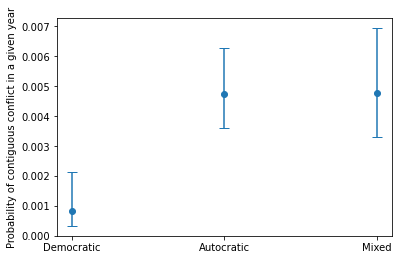

In [112]:
plt.errorbar(
    ["Democratic", "Autocratic", "Mixed"], 
    [estimate_contig_p_dem_dyad, estimate_contig_p_non_dem_dyad, estimate_contig_p_mixed_dyad], # estimates
    yerr=[[error_low_contig_p_dem_dyad, error_low_contig_p_non_dem_dyad, error_low_contig_p_mixed_dyad], # lower
          [error_high_contig_p_dem_dyad, error_high_contig_p_non_dem_dyad, error_high_contig_p_mixed_dyad]], # upper
    fmt='o', 
    capsize=5
)
plt.ylabel("Probability of contiguous conflict in a given year")
plt.savefig("../paper/figures/contiguous_conflict_probabilities.png")

N states
draw from binomial for num democratic states
each state has 4 neighbors
for each state:
  draw from binomial for num dem neighbors (given regime type of current state)
compute expected num conflicts in system

In [34]:
# 13x13 = 169, current_num_countries is 166
G = nx.grid_2d_graph(13, 13, periodic=False, create_using=None)

In [35]:
# That is spookily close
np.mean([G.degree(n) for n in G.nodes()])

3.6923076923076925

In [67]:
def is_dem(p_dem):
    if random.random() < p_dem:
        return 1
    else:
        return 0

def randomize_regime_types(G, p_dem):
    for node in G.nodes:
        G.nodes[node]['dem'] = is_dem(p_dem)
    return G

def generate_graph(p_dem):
    G = nx.grid_2d_graph(13, 13, periodic=False, create_using=None)
    for node in G.nodes:
        G.nodes[node]['dem'] = is_dem(p_dem)
    return G
    
def count_dyads(G):
    num_dem_dyads = 0
    num_auto_dyads = 0
    num_mixed_dyads = 0
    
    for u, v in G.edges:
        u = G.nodes[u]
        v = G.nodes[v]
        if u['dem'] == 1 and v['dem'] == 1:
            num_dem_dyads += 1
        elif u['dem'] == 0 and v['dem'] == 0:
            num_auto_dyads += 1
        else:
            num_mixed_dyads += 1
    return (num_dem_dyads, num_auto_dyads, num_mixed_dyads)

def calc_expected_num_wars(G, p_dem_conflict, p_auto_conflict, p_mixed_conflict):
    num_dem_dyads, num_auto_dyads, num_mixed_dyads = count_dyads(G)
    return num_dem_dyads * p_dem_conflict + num_auto_dyads * p_auto_conflict + num_mixed_dyads * p_mixed_conflict

# If I wasn't an idiot this would be multiplication
def avg_dyad_counts(p_dem, num_iterations = 30):
    num_dem_dyads = []
    num_auto_dyads = []
    num_mixed_dyads = []
    for i in range(num_iterations):
        a, b, c = count_dyads(generate_graph(p_dem))
        num_dem_dyads.append(a)
        num_auto_dyads.append(b)
        num_mixed_dyads.append(c)
    return (np.mean(num_dem_dyads), np.mean(num_auto_dyads), np.mean(num_mixed_dyads))

def get_dem_nodes(G):
    return [node for node in G.nodes if G.nodes[node]['dem'] == 1]

def get_dem_nodes_sorted_by_dem_neighbors(G):
    d = {}
    for node in G.nodes:
        if G.nodes[node]['dem'] != 1:
            continue
        count = 0
        for neighbor in G.neighbors(node):
            if G.nodes[neighbor]['dem'] == 1:
                count += 1
        d[node] = count
    return [i[0] for i in sorted(d.items(), key = lambda x: x[1], reverse=True)]

## Trajectories with grid graph (unused)

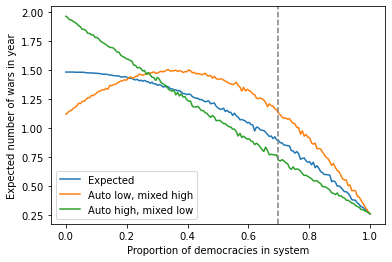

In [37]:
def generate_expected_num_contiguous_conflicts_trajectory(
    current_num_countries, 
    p_dem_conflict, 
    p_non_dem_conflict, 
    p_mixed_conflict
):
    dem_countries = []
    expected_num_conflicts = []
    for num_dem_countries in range(0, current_num_countries+1):
        num_non_dem_countries = current_num_countries - num_dem_countries
        
        num_dem_dyads, num_non_dem_dyads, num_mixed_dyads = avg_dyad_counts(num_dem_countries/current_num_countries)

        expectation = num_dem_dyads * p_dem_conflict + num_non_dem_dyads * p_non_dem_conflict + num_mixed_dyads * p_mixed_conflict

        dem_countries.append(num_dem_countries)
        expected_num_conflicts.append(expectation)
    return (dem_countries, expected_num_conflicts)

dem_countries, expected_num_conflicts = generate_expected_num_contiguous_conflicts_trajectory(current_num_countries, estimate_contig_p_dem_dyad, estimate_contig_p_non_dem_dyad, estimate_contig_p_mixed_dyad)
# name order is non-dem, mixed
#_, expected_num_conflicts_low_low = generate_expected_num_contiguous_conflicts_trajectory(current_num_countries, estimate_contig_p_dem_dyad, ci_low_contig_p_non_dem_dyad, ci_low_contig_p_mixed_dyad)
_, expected_num_conflicts_low_high = generate_expected_num_contiguous_conflicts_trajectory(current_num_countries, estimate_contig_p_dem_dyad, ci_low_contig_p_non_dem_dyad, ci_high_contig_p_mixed_dyad)
_, expected_num_conflicts_high_low = generate_expected_num_contiguous_conflicts_trajectory(current_num_countries, estimate_contig_p_dem_dyad, ci_high_contig_p_non_dem_dyad, ci_low_contig_p_mixed_dyad)
#_, expected_num_conflicts_high_high = generate_expected_num_contiguous_conflicts_trajectory(current_num_countries, estimate_contig_p_dem_dyad, ci_high_contig_p_non_dem_dyad, ci_high_contig_p_mixed_dyad)

dem_countries = [i/current_num_countries for i in dem_countries] # turn to proportion
plt.plot(dem_countries, expected_num_conflicts, label="Expected")
#plt.plot(dem_countries, expected_num_conflicts_low_low)
plt.plot(dem_countries, expected_num_conflicts_low_high, label="Auto low, mixed high")
plt.plot(dem_countries, expected_num_conflicts_high_low, label="Auto high, mixed low")
#plt.plot(dem_countries, expected_num_conflicts_high_high)
plt.axvline(x=current_num_dem_countries/current_num_countries, color='grey', ls='--')
plt.legend()
plt.xlabel("Proportion of democracies in system")
plt.ylabel("Expected number of wars in year")
plt.show()

In [38]:
def get_avg_degree(G, source_is_dem = 1, target_is_dem = 1):
    counts = []
    for node in G.nodes:
        if G.nodes[node]['dem'] != source_is_dem:
            continue
        count = 0
        for neighbor in G.neighbors(node):
            if target_is_dem == None or G.nodes[neighbor]['dem'] == target_is_dem:
                count += 1
        counts.append(count)
    return np.mean(counts)
        

G = generate_graph(current_num_dem_countries/current_num_countries)

# Expected num neighbors for dem: 3.267051528757751
# Expected num dem neighbors for dem: 2.057729313662604
# Expected num auto neighbors for dem: 1.2093222150951464
# Expected num neighbors for auto: 3.363494539781591
# Expected num dem neighbors for auto: 0.735309412376495
# Expected num dem neighbors for auto: 2.628185127405096

n_d = []
n_d_d = []
n_d_a = []
n_a = []
n_a_d = []
n_a_a = []
assorts = []
for i in range(200):
    G = generate_graph(current_num_dem_countries/current_num_countries)
    n_d.append(get_avg_degree(G, 1, None))
    n_d_d.append(get_avg_degree(G, 1, 1))
    n_d_a.append(get_avg_degree(G, 1, 0))
    n_a.append(get_avg_degree(G, 0, None))
    n_a_d.append(get_avg_degree(G, 0, 1))
    n_a_a.append(get_avg_degree(G, 0, 0))
    assorts.append(nx.attribute_assortativity_coefficient(G, 'dem'))

print(current_num_dem_countries/current_num_countries)
print(f"Expected num neighbors for dem: {np.mean(n_d)}")
print(f"Expected num dem neighbors for dem: {np.mean(n_d_d)}")
print(f"Expected num auto neighbors for dem: {np.mean(n_d_a)}")
print(f"Expected num neighbors for auto: {np.mean(n_a)}")
print(f"Expected num dem neighbors for auto: {np.mean(n_a_d)}")
print(f"Expected num auto neighbors for auto: {np.mean(n_a_a)}")
print(f"Assortativity: {np.mean(assorts)}")

0.6987951807228916
Expected num neighbors for dem: 3.693285333171033
Expected num dem neighbors for dem: 2.5682522355212143
Expected num auto neighbors for dem: 1.1250330976498197
Expected num neighbors for auto: 3.689082885707435
Expected num dem neighbors for auto: 2.561459806222633
Expected num auto neighbors for auto: 1.1276230794848021
Assortativity: 0.0008300096965674195


## Empirical Assortativity

In [126]:
empG = nx.Graph()

tmp = undirectedcontigdf[undirectedcontigdf.year == 2015]

for index, row in tmp.iterrows():
    if not row.ccode_x in empG:
        empG.add_node(row.ccode_x)
        empG.nodes[row.ccode_x]['dem'] = int(row.polity_x > dem_thres)
    if not row.ccode_y in empG:
        empG.add_node(row.ccode_y)
        empG.nodes[row.ccode_y]['dem'] = int(row.polity_y > dem_thres)
    empG.add_edge(row.ccode_x, row.ccode_y)

print(len(empG))
print(empG.number_of_edges())

print(np.mean([empG.degree(n) for n in empG.nodes()]))
print(sum([empG.nodes[i]['dem'] for i in empG.nodes]))
print(nx.attribute_assortativity_coefficient(empG, 'dem'))
print(avg_dyad_counts(100/146))
count_dyads(empG)


146
278
3.808219178082192
100
0.3554485464597824
(144.0, 33.266666666666666, 134.73333333333332)


(150, 50, 78)

In [40]:
d = {}
for node in empG.nodes:
    if empG.nodes[node]['dem'] != 1:
        continue
    count = 0
    for neighbor in empG.neighbors(node):
        if empG.nodes[neighbor]['dem'] == 1:
            count += 1
    d[node] = count
nodes_with_d_neighbors = list(sorted(d.items(), key = lambda x: x[1], reverse=True))

print(len(nodes_with_d_neighbors))


100


In [41]:
top_nodes_to_switch = [i[0] for i in nodes_with_d_neighbors[0:10]]
bottom_nodes_to_switch = [i[0] for i in nodes_with_d_neighbors[-10:]]

In [45]:
empirical_expected_num_wars = calc_expected_num_wars(empG, estimate_contig_p_dem_dyad, estimate_contig_p_non_dem_dyad, estimate_contig_p_mixed_dyad)
empirical_expected_num_wars


0.7344719228817744

In [43]:
tmp = empG.copy()
for node in top_nodes_to_switch:
    assert(tmp.nodes[node]['dem'] == 1)
    tmp.nodes[node]['dem'] = 0
calc_expected_num_wars(tmp, estimate_contig_p_dem_dyad, estimate_contig_p_non_dem_dyad, estimate_contig_p_mixed_dyad)



0.9823958200644174

In [44]:
tmp = empG.copy()
for node in bottom_nodes_to_switch:
    assert(tmp.nodes[node]['dem'] == 1)
    tmp.nodes[node]['dem'] = 0
calc_expected_num_wars(tmp, estimate_contig_p_dem_dyad, estimate_contig_p_non_dem_dyad, estimate_contig_p_mixed_dyad)


0.7537345054113989

In [52]:
num_dem_neighbors = []
percent_increases = []
tmp = empG.copy()
for node in tmp.nodes:
    if tmp.nodes[node]['dem'] != 1:
        continue
    count = 0
    for neighbor in tmp.neighbors(node):
        if tmp.nodes[neighbor]['dem'] == 1:
            count += 1
    
    # Slide one node
    tmp.nodes[node]['dem'] = 0
    
    enw = calc_expected_num_wars(tmp, estimate_contig_p_dem_dyad, estimate_contig_p_non_dem_dyad, estimate_contig_p_mixed_dyad)
    
    # Un-slide for next round
    tmp.nodes[node]['dem'] = 1

    num_dem_neighbors.append(count)
    percent_increases.append(((enw/empirical_expected_num_wars) - 1) * 100)
    

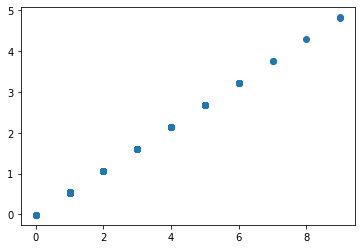

In [53]:
plt.scatter(num_dem_neighbors, percent_increases)

In [118]:
num_sliding = 5
p_dem = current_num_dem_countries/current_num_countries

assorts = []
percent_increases = []
for i in range(2000):
    tmp = randomize_regime_types(empG.copy(), p_dem)
    
    initial_expected_conflict = calc_expected_num_wars(tmp, estimate_contig_p_dem_dyad, estimate_contig_p_non_dem_dyad, estimate_contig_p_mixed_dyad)
    assorts.append(nx.attribute_assortativity_coefficient(tmp, 'dem'))
    
    #dem_nodes = get_dem_nodes(tmp)
    # sample [num_sliding] nodes without replacement
    #nodes_to_slide = random.sample(dem_nodes, num_sliding)
    # Get top [num_sliding] nodes by num dem neighbors
    nodes_to_slide = get_dem_nodes_sorted_by_dem_neighbors(tmp)[0:num_sliding]
    # Slide em
    for node in nodes_to_slide:
        assert(tmp.nodes[node]['dem'] == 1)
        tmp.nodes[node]['dem'] = 0
    final_expected_conflict = calc_expected_num_wars(tmp, estimate_contig_p_dem_dyad, estimate_contig_p_non_dem_dyad, estimate_contig_p_mixed_dyad)

    percent_increases.append(((final_expected_conflict/initial_expected_conflict) - 1) * 100)
    

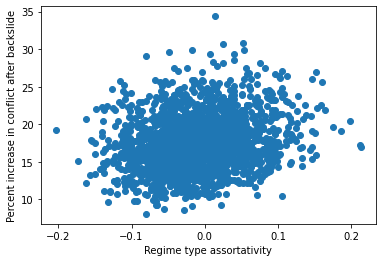

In [120]:
plt.scatter(assorts, percent_increases)
plt.ylabel("Percent increase in conflict after backslide")
plt.xlabel("Regime type assortativity")
plt.savefig("../paper/figures/top_sliding.png")


In [116]:
slope, intercept, r_value, p_value, std_err = linregress(assorts, percent_increases)
print(slope)
print(r_value)

12.652972933620863
0.21097330826081107


In [127]:
num_sliding = 5
p_dem = current_num_dem_countries/current_num_countries

assorts = []
percent_increases = []
for i in range(2000):
    tmp = randomize_regime_types(empG.copy(), p_dem)
    
    initial_expected_conflict = calc_expected_num_wars(tmp, estimate_contig_p_dem_dyad, estimate_contig_p_non_dem_dyad, estimate_contig_p_mixed_dyad)
    assorts.append(nx.attribute_assortativity_coefficient(tmp, 'dem'))
    
    #dem_nodes = get_dem_nodes(tmp)
    # sample [num_sliding] nodes without replacement
    #nodes_to_slide = random.sample(dem_nodes, num_sliding)
    # Get bottom [num_sliding] nodes by num dem neighbors
    nodes_to_slide = get_dem_nodes_sorted_by_dem_neighbors(tmp)[-num_sliding:]
    # Slide em
    for node in nodes_to_slide:
        assert(tmp.nodes[node]['dem'] == 1)
        tmp.nodes[node]['dem'] = 0
    final_expected_conflict = calc_expected_num_wars(tmp, estimate_contig_p_dem_dyad, estimate_contig_p_non_dem_dyad, estimate_contig_p_mixed_dyad)

    percent_increases.append(((final_expected_conflict/initial_expected_conflict) - 1) * 100)
    

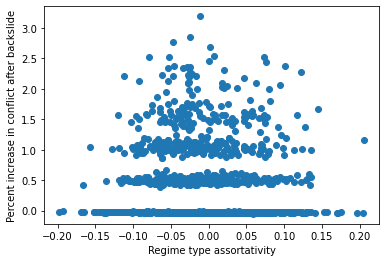

In [128]:
plt.scatter(assorts, percent_increases)
plt.ylabel("Percent increase in conflict after backslide")
plt.xlabel("Regime type assortativity")
plt.savefig("../paper/figures/bottom_sliding.png")


In [123]:
slope, intercept, r_value, p_value, std_err = linregress(assorts, percent_increases)
print(slope)
print(r_value)

0.4596031902537833
0.047630232669111774


In [129]:
assorts = []
for i in range(2000):
    tmp = randomize_regime_types(empG.copy(), p_dem)
    assorts.append(nx.attribute_assortativity_coefficient(tmp, 'dem'))

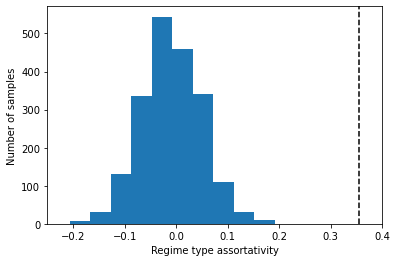

In [134]:
plt.hist(assorts)
plt.ylabel("Number of samples")
plt.xlabel("Regime type assortativity")
plt.xlim([-0.25, 0.4])
plt.axvline(x=nx.attribute_assortativity_coefficient(empG, 'dem'), color='black', ls='--')
plt.savefig("../paper/figures/assort_distribution.png")
